In [245]:
import os, re, string, json, pickle
from pathlib import Path
import pandas as pd
import numpy as np

In [246]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from difflib import get_close_matches
import argparse

In [247]:
df1 = pd.read_csv("Audible_Catlog.csv")
df2 = pd.read_csv("Audible_Catlog_Advanced_Features.csv")

In [248]:
df1.head(2)

,Book Name,Author,Rating,Number of Reviews,Price
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,313.0,10080.0
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3658.0,615.0


In [249]:
df2.head(2)

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."


In [250]:
def canonical_cols(cols):
    mapping = {}
    for c in cols:
        if "title" in c: mapping[c] = "title"
        elif "author" in c: mapping[c] = "author"
        elif "rating" in c: mapping[c] = "rating"
        elif "genre" in c or "rank" in c: mapping[c] = "genre"
        elif "description" in c or "about" in c: mapping[c] = "description"
        else: mapping[c] = c
    return mapping

In [251]:
df1 = df1.rename(columns=canonical_cols(df1.columns))
df2 = df2.rename(columns=canonical_cols(df2.columns))


In [252]:
df2

,Book Name,Author,Rating,Number of Reviews,Price,Description,Listening Time,Ranks and Genre
0,Think Like a Monk: The Secret of How to Harnes...,Jay Shetty,4.9,371.0,10080,"Over the past three years, Jay Shetty has beco...",10 hours and 54 minutes,",#1 in Audible Audiobooks & Originals (See Top..."
1,Ikigai: The Japanese Secret to a Long and Happ...,Héctor García,4.6,3682.0,615,Brought to you by Penguin.,3 hours and 23 minutes,",#2 in Audible Audiobooks & Originals (See Top..."
2,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,4.4,20306.0,10378,"In this generation-defining self-help guide, a...",5 hours and 17 minutes,",#3 in Audible Audiobooks & Originals (See Top..."
3,Atomic Habits: An Easy and Proven Way to Build...,James Clear,4.6,4678.0,888,Brought to you by Penguin.,5 hours and 35 minutes,",#5 in Audible Audiobooks & Originals (See Top..."
4,Life's Amazing Secrets: How to Find Balance an...,Gaur Gopal Das,4.6,4308.0,1005,"Stop going through life, Start growing throug...",6 hours and 25 minutes,",#6 in Audible Audiobooks & Originals (See Top..."
...,...,...,...,...,...,...,...,...
4459,"Factfulness: Wie wir lernen, die Welt so zu se...",Hans Rosling,4.6,72.0,703,"Sorry, we just need to make sure you're not a ...",-1,-1
4460,Late-Talking Children: A Symptom or a Stage?,Stephen M. Camarata,4.6,92.0,703,"Sorry, we just need to make sure you're not a ...",-1,-1
4461,"The Marketing of Evil: How Radicals, Elitists ...",David Kupelian,4.7,490.0,586,"Americans have come to tolerate, embrace, and ...",-1,-1
4462,Things I Wish I'd Known Before We Got Married,Gary Chapman,4.7,1388.0,516,\n\nOops!\nIt's rush hour and traffic is pilin...,-1,-1


In [253]:
print(df1.columns.tolist())
print(df2.columns.tolist())


['Book Name', 'Author', 'Rating', 'Number of Reviews', 'Price']
['Book Name', 'Author', 'Rating', 'Number of Reviews', 'Price', 'Description', 'Listening Time', 'Ranks and Genre']


In [254]:
df1["title_key"] = df1["Book Name"].astype(str).str.lower().str.strip()
df2["title_key"] = df2["Book Name"].astype(str).str.lower().str.strip()


In [255]:
merged = pd.merge(df1, df2, on="title_key", how="outer", suffixes=("_a", "_b"))

In [259]:
merged.head(5)

,Book Name_a,Author_a,Rating_a,Number of Reviews_a,Price_a,title_key,Book Name_b,Author_b,Rating_b,Number of Reviews_b,Price_b,Description,Listening Time,Ranks and Genre
0,"""Don't You Know Who I Am?"": How to Stay Sane i...",Ramani S. Durvasula PhD,4.8,170.0,836.0,"""don't you know who i am?"": how to stay sane i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#Girlboss,Sophia Amoruso,4.5,2260.0,615.0,#girlboss,#Girlboss,Sophia Amoruso,4.5,2272.0,615.0,"Sorry, we just need to make sure you're not a ...",-1,-1
3,#Girlboss,Sophia Amoruso,4.5,2260.0,615.0,#girlboss,#Girlboss,Sophia Amoruso,4.5,2272.0,615.0,"Penguin presents the unabridged downloadable, ...",-1,-1
4,#TheRealCinderella: #BestFriendsForever Series...,Yesenia Vargas,4.3,179.0,586.0,#therealcinderella: #bestfriendsforever series...,#TheRealCinderella: #BestFriendsForever Series...,Yesenia Vargas,4.3,179.0,586.0,\n\nOops!\nIt's rush hour and traffic is pilin...,-1,-1
5,10 Bedtime Stories For Little Kids,div.,-1.0,NaN,376.0,10 bedtime stories for little kids,10 Bedtime Stories For Little Kids,div.,-1.0,NaN,376.0,\nBy completing your purchase you agree to Aud...,-1,-1


In [260]:
merged.drop_duplicates(inplace=True)

In [261]:
# --- Clean Genre ---
if "genre" in merged.columns:
    merged["genre"] = merged["genre"].astype(str).str.strip()

    # Replace invalid values with Unknown
    merged["genre"] = merged["genre"].replace(
        ["-1", "nan", "NaN", "None"], "Unknown"
    )

    # Extract meaningful genre part if it contains "in ..."
    merged["genre"] = merged["genre"].apply(
        lambda x: x.split(" in ")[-1] if " in " in x else x
    )

In [262]:
# --- Clean Description ---
if "description" in merged.columns:
    merged["description"] = merged["description"].fillna("No description available")

    # Remove placeholder junk text
    merged["description"] = merged["description"].replace(
        to_replace=r"^Sorry.*", 
        value="No proper description available", 
        regex=True
    )
    # Clean newlines and extra spaces
    merged["description"] = merged["description"].apply(
        lambda x: x.replace("\\n", " ").replace("\n", " ").strip()
    )

In [263]:
def pick_first(row, candidates):
    for c in candidates:
        if c in row and pd.notnull(row[c]) and str(row[c]).strip() != "":
            return row[c]
    return np.nan

In [264]:
cols = merged.columns

In [265]:
# Flexible mapping
title_cols = [c for c in cols if "title" in c.lower() or "book" in c.lower()]
author_cols = [c for c in cols if "author" in c.lower()]
rating_cols = [c for c in cols if "rating" in c.lower()]
genre_cols = [c for c in cols if "genre" in c.lower()]
desc_cols = [c for c in cols if "desc" in c.lower()]

In [266]:
merged["title"] = merged.apply(lambda r: pick_first(r, title_cols), axis=1)
merged["author"] = merged.apply(lambda r: pick_first(r, author_cols), axis=1)
merged["rating"] = merged.apply(lambda r: pick_first(r, rating_cols), axis=1)
merged["genre"] = merged.apply(lambda r: pick_first(r, genre_cols), axis=1)
merged["description"] = merged.apply(lambda r: pick_first(r, desc_cols), axis=1)

In [267]:
merged = merged[["title", "author", "rating", "genre", "description"]].drop_duplicates().reset_index(drop=True)

In [268]:
# EDA
# ------------------
print("Number of books:", len(merged))
print("Unique authors:", merged['author'].nunique())


Number of books: 6356
Unique authors: 3875


In [269]:
# Ratings
merged["rating"] = pd.to_numeric(merged["rating"], errors="coerce")
print("Average rating:", merged["rating"].mean())

Average rating: 3.928193832599119


In [270]:
merged.head(2)

,title,author,rating,genre,description
0,"""Don't You Know Who I Am?"": How to Stay Sane i...",Ramani S. Durvasula PhD,4.8,NaN,NaN
1,#Girlboss,Sophia Amoruso,4.5,-1,"Sorry, we just need to make sure you're not a ..."


In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

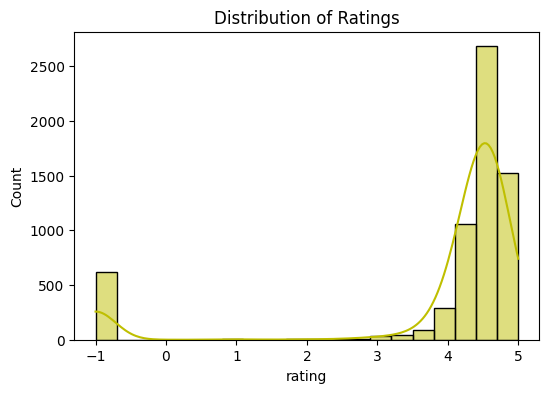

In [272]:
plt.figure(figsize=(6,4))
sns.histplot(merged["rating"].dropna(), bins=20, kde=True, color='y')
plt.title("Distribution of Ratings")
plt.show()

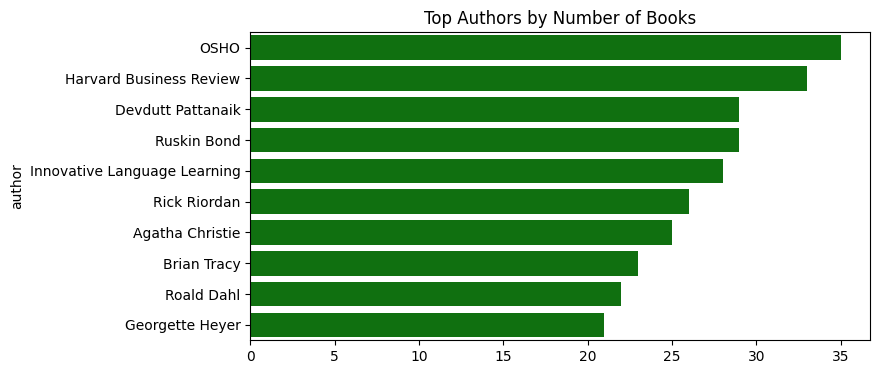

In [273]:
# Top authors
top_authors = merged["author"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_authors.values, y=top_authors.index, color= 'g')
plt.title("Top Authors by Number of Books")
plt.show()

In [274]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [275]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt


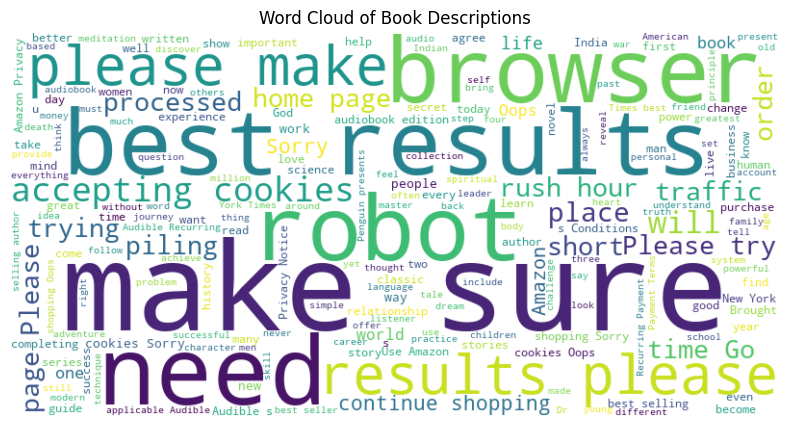

In [276]:
# Word cloud from descriptions
text = " ".join(str(d) for d in merged["description"].dropna())
wc = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Book Descriptions")
plt.show()

In [277]:
# NLP: TF-IDF
# ------------------
def clean_text(s):
    if pd.isnull(s): return ""
    s = str(s).lower()
    s = re.sub(r"\s+", " ", s)
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s.strip()

In [278]:
merged["combined_text"] = (
    merged["title"].fillna("") + " " +
    merged["author"].fillna("") + " " +
    merged["genre"].fillna("") + " " +
    merged["description"].fillna("")
).apply(clean_text)

In [279]:
merged.head(2)

,title,author,rating,genre,description,combined_text
0,"""Don't You Know Who I Am?"": How to Stay Sane i...",Ramani S. Durvasula PhD,4.8,NaN,NaN,dont you know who i am how to stay sane in an ...
1,#Girlboss,Sophia Amoruso,4.5,-1,"Sorry, we just need to make sure you're not a ...",girlboss sophia amoruso 1 sorry we just need t...


In [280]:
tfidf = TfidfVectorizer(max_features=3000, stop_words="english")
X_tfidf = tfidf.fit_transform(merged["combined_text"])

In [281]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

In [282]:
# Clustering
# ------------------
# KMeans
best_k, best_score = 0, -1
for k in range(4, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_svd)
    score = silhouette_score(X_svd, labels)
    if score > best_score:
        best_k, best_score = k, score

In [283]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
merged["kmeans_cluster"] = kmeans.fit_predict(X_svd)

In [284]:
# DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_svd)
db = DBSCAN(eps=0.8, min_samples=5)
merged["dbscan_cluster"] = db.fit_predict(X_scaled)

In [285]:
# DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_svd)
db = DBSCAN(eps=0.8, min_samples=5)
merged["dbscan_cluster"] = db.fit_predict(X_scaled)

In [286]:
# Recommendation function
# ------------------
sim = cosine_similarity(X_svd)
title_to_index = {t.lower(): i for i,t in enumerate(merged["title"].astype(str))}

In [287]:
def recommend_by_title(title, n=5):
    q = normalize_text(title)

    # Fuzzy/difflib match
    if q not in title_to_index:
        matches = get_close_matches(q, title_to_index.keys(), n=1, cutoff=0.5)
        if matches:
            q = matches[0]
        else:
            return []

    idx = title_to_index[q]
    scores = list(enumerate(sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    recs = []
    for i, sc in scores[1:n+1]:
        recs.append({
            "Title": merged.loc[i, "title"],
            "Author": merged.loc[i, "author"],
            "Genre": merged.loc[i, "genre"] if "genre" in merged.columns else "",
            "Rating": merged.loc[i, "rating"] if "rating" in merged.columns else "",
            "Description": merged.loc[i, "description"] if "description" in merged.columns else "",
            "Similarity": round(sc, 3)
            # 👆 Cluster removed from what’s returned
        })
    return recs



In [288]:
# Generate recommendations for ALL books
all_recommendations = {}

for idx, title in enumerate(merged["title"].dropna().unique()):
    # Get similarity scores for this book
    scores = list(enumerate(sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    recs = []
    for i, sc in scores[1:6]:  # top 5 recommendations, skip itself
        recs.append({
            "Title": merged.loc[i, "title"],
            "Author": merged.loc[i, "author"] if "author" in merged.columns else "",
            "Genre": merged.loc[i, "genre"] if "genre" in merged.columns else "",
            "Rating": merged.loc[i, "rating"] if "rating" in merged.columns else "",
            "Description": merged.loc[i, "description"] if "description" in merged.columns else "",
            "Similarity": round(sc, 3)
        })
    
    all_recommendations[title] = recs


In [294]:
merged.sample(5)

,title,author,rating,genre,description,combined_text,kmeans_cluster,dbscan_cluster
3461,"Republic, Lost: How Money Corrupts Congress - ...",Lawrence Lessig,4.5,NaN,NaN,republic lost how money corrupts congress and...,4,-1
4258,The Book of Hygge: The Danish Art of Living Well,Louisa Thomsen Brits,4.3,-1,\n\nOops!\nIt's rush hour and traffic is pilin...,the book of hygge the danish art of living wel...,0,-1
1061,"Curse of the Arctic Star: Nancy Drew Diaries, ...",Carolyn Keene,4.5,",#2,898 in Audible Audiobooks & Originals (See...","Dear Diary...Bess, George, and I are actually ...",curse of the arctic star nancy drew diaries bo...,2,-1
1045,Crush It!: Why NOW Is the Time to Cash In on Y...,Gary Vaynerchuk,4.4,-1,\n\nOops!\nIt's rush hour and traffic is pilin...,crush it why now is the time to cash in on you...,0,-1
4775,The Hard Way: Jack Reacher 10,Lee Child,4.6,-1,Late at night in a New York café army-cop-turn...,the hard way jack reacher 10 lee child 1 late ...,4,-1


In [290]:
import joblib
import os



In [291]:
os.makedirs("artifacts", exist_ok=True)

In [292]:
merged.to_csv("artifacts/merged_books.csv", index=False)

In [293]:
joblib.dump(tfidf, "artifacts/tfidf_vectorizer.joblib")
joblib.dump(svd, "artifacts/svd_transform.joblib")
joblib.dump(kmeans, "artifacts/kmeans_model.joblib")
joblib.dump(sim, "artifacts/cosine_similarity_matrix.joblib")

['artifacts/cosine_similarity_matrix.joblib']